# Phase transition in a hard-disk fluid

In [1]:
include("gnuplot.jl");

## The box

A box is created with random points. This points will become the centers of particles of a given radius. Notice that the distance from point to point (or center to center) restricts the possible radii that the particles can take without overlapping. To get any desired radius is just a matter of rescaling the system.

In [2]:
mutable struct Point
    x::Float64
    y::Float64
    Point() = new(rand(),rand())
end

struct Box
    pts::Vector{Point}
    params::Vector{Float64}
    
    function Box(nPts::Int, radius::Float64)
        # Random points inside a unit box
        pts::Vector{Point} = [Point() for i in 1:nPts]

        # The minimum distance between all pairs of points is the
        # allowed radius of the particles (previously points).
        minDist = Inf
        for i in 1:nPts-1, j in i+1:nPts
            rx = pts[i].x - pts[j].x
            ry = pts[i].y - pts[j].y
            dist = rx*rx + ry*ry
            if dist < minDist
                minDist = dist
            end
        end
        r = sqrt(minDist)/2.0 - 1e-10

        # Scale the system to get the desired radius.
        # Translate the system to get left and bottom walls at x,y = 0
        f = radius/r # scaling factor
        for p in pts
            p.x = p.x*f + radius
            p.y = p.y*f + radius
        end
        
        return new(pts,[radius,f+2*radius])
    end
end

function getParticleRadius(box::Box)
    return box.params[1]
end

function getSize(box::Box)
    return box.params[2]
end

function setSize!(box::Box,w::Float64)
    box.params[2] = w
end

function getDensity(box::Box)
    radius = box.params[1]
    size = box.params[2]
    volume = size*size
    nPts = length(box.pts)
    phi = nPts*pi*radius*radius/volume
end

getDensity (generic function with 1 method)

## Hard-disks collisions, a montecarlo process

Instead of physically colliding disks inside the box, we are simulating their dynamics with a montecarlo process:

- Randomly pick a disk inside the box and move it in a random direction with magnitude between 0 and 1. 
- If the particle overlaps with another one or if it leaves the box, then return particle to original position.

We can also reduce the volume of the box cuasi-statically to reach an optimal packing.

In [3]:
function montecarlo!(box::Box)
    # Random disk
    p = rand(box.pts)
    
    # Random movement of magnitude between 0 and 1
    x = -1 + 2*rand()
    y = -1 + 2*rand()
    n = sqrt(x*x + y*y) # Norm
    A = rand() # Amplitude
    x = p.x + A*x/n
    y = p.y + A*y/n
    
    # Are there any overlaps inside the box?
    # Minimum allowed distance between particles is 2r.
    w = getSize(box)
    r = getParticleRadius(box)
    l = w - r
    if (r < x < l) && (r < y < l)
        overlaps = false
        for q in box.pts
            if p === q; continue; end
            rx = x - q.x
            ry = y - q.y
            if rx*rx + ry*ry < 4*r*r
                overlaps = true
                break;
            end
        end
        if !overlaps
            p.x = x
            p.y = y
        end
    end
end

function reduceVolume!(box::Box)
    xdist2wall = Inf
    ydist2wall = Inf
    w = getSize(box)
    r = getParticleRadius(box)
    l = w - r
    for p in box.pts
        x = l - p.x
        y = l - p.y
        if x < xdist2wall; xdist2wall = x; end
        if y < ydist2wall; ydist2wall = y; end
    end
    setSize!(box, w - min(xdist2wall, ydist2wall)/2.0)
end

function incrementVolume!(box::Box)
    w = getSize(box)
    setSize!(box, w*(1.001)) # 0.1% increment
end

incrementVolume! (generic function with 1 method)

### A fresh new box

Let's start a new box with $n$ disks of radius $r$ and measure its packing fraction $\phi$.

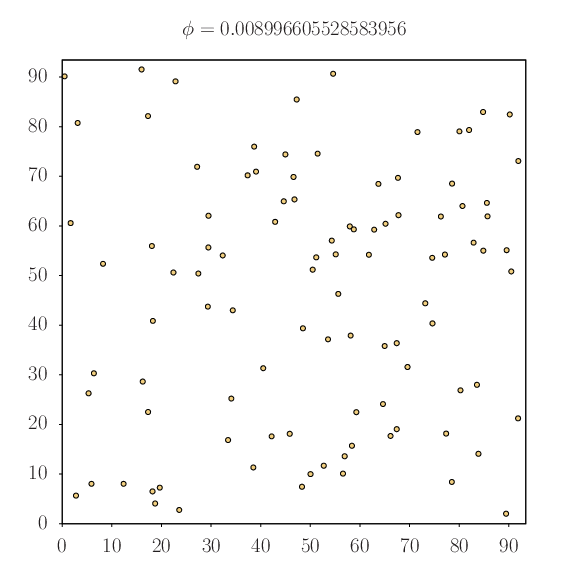

In [4]:
r = 0.5; n = 100;
box = Box(n,r)

l = getSize(box)
phi = getDensity(box)

gp = Gnuplot("disks.png", 20, 20)
write(gp.f, "set size ratio -1; set tics out nomirror;
    set style fill solid 0.5 border 1;
    set xrange [0:$l]; set yrange [0:$l];
    set title '\$\\phi = $phi\$';
    plot '-' with circles lc 2 notitle\n")
for p in box.pts
    write(gp.f, "$(p.x) $(p.y) $r\n")
end
plot(gp)

### An old box

Take the previous box and let the montecarlo process simulate its dynamics. After a given number of montecarlo steps try to reduce the system's volume. This way, each volume reducing step, the packing fraction will increase.

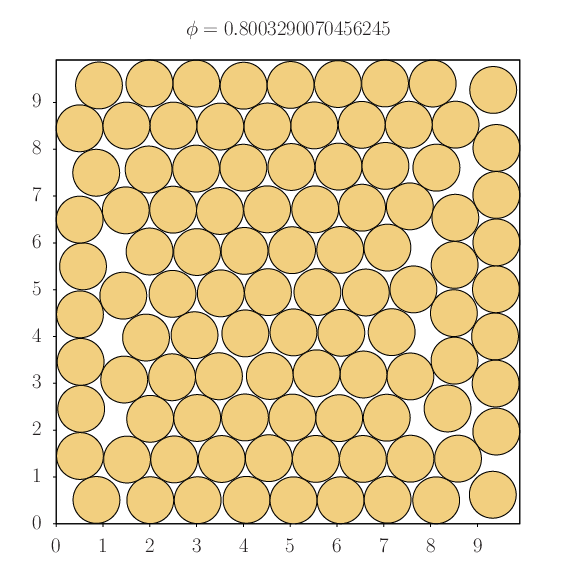

In [5]:
for i in 1:100000
    for k in 1:length(box.pts)
        montecarlo!(box)
    end
    reduceVolume!(box)
end

l = getSize(box)
phi = getDensity(box)

gp = Gnuplot("disks.png", 20, 20)
write(gp.f, "set size ratio -1; set tics out nomirror;
    set style fill solid 0.5 border 1;
    set xrange [0:$l]; set yrange [0:$l];
    set title '\$\\phi = $phi\$';
    plot '-' with circles lc 2 notitle\n")
for p in box.pts
    write(gp.f, "$(p.x) $(p.y) $r\n")
end
plot(gp)

## Orientational order parameter

$$ \psi_6(R) = \frac{1}{N}\sum_{j=1}^N \bigg| \frac{1}{n} \sum_{k=1}^n \exp(i 6 \theta_{jk})\bigg| $$

where $R$ is a radius defining a circle concentric with particle $p_j$ and enclosing all particles $p_k$.

In [6]:
function psi6(pts::Vector{Point}, r::Float64)
    RePsi = 0
    ImPsi = 0
    psi6 = 0
    N = length(pts)
    for p in pts
        n = 0 # count p-neighbours
        for q in pts
            if p === q; continue; end
            rx = q.x - p.x
            ry = q.y - p.y
            d = rx*rx + ry*ry
            th = atan2(ry,rx)
            if d < r
                RePsi += cos(6*th)
                ImPsi += sin(6*th)
                n += 1
            end
        end
        if n > 0
            psi6 += sqrt(RePsi*RePsi + ImPsi*ImPsi)/n
        end
    end
    return psi6/N
end

psi6 (generic function with 1 method)

### Plotting $\psi_6(R)$ for different densities $\phi$.

Plotted in units of the particles' diameter, $d$

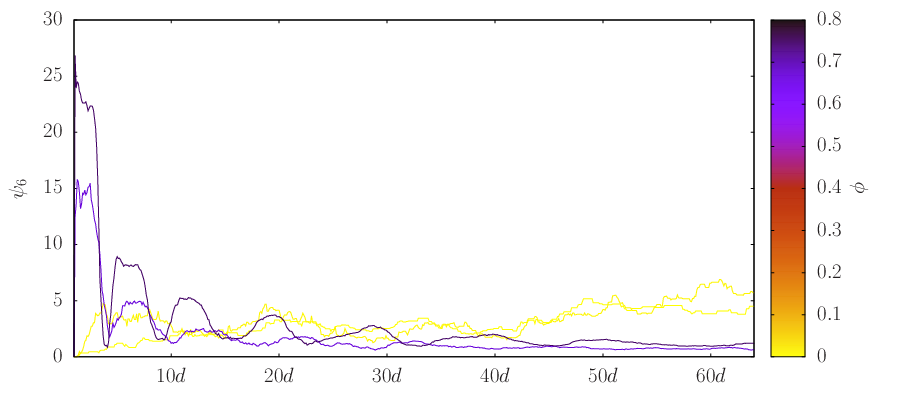

In [7]:
n = 100; r = 0.5
box = Box(n,r)

gp = Gnuplot("psi6.png", 32,14)
write(gp.f, "set cblabel '\$\\phi\$'; set palette negative;
    set format x '\$%1.0f d\$'; set ylabel '\$\\psi_6\$';
    set xrange [2*$r:128*$r];
    plot '-' w l lc palette notitle\n")
for i in 1:4
    # Change box's density
    for j in 1:20000
        for k in 1:length(box.pts)
            montecarlo!(box)
        end
        reduceVolume!(box)
    end

    # Plot psi6(R) for fixed density
    phi = getDensity(box)
    for R in 2*r:1e-1:128*r
        p = psi6(box.pts, R)
        write(gp.f, "$R $p $phi\n")
    end
    write(gp.f, "\n\n")
end
plot(gp)

### Fixing $R$ and measuring $\psi_6^{(R)}(\phi)$

We observed in the previous result the values of $R$ that make the order parameter a measurable quantity. Taking one of this values we can then slowly change the box's density and measure $\psi_6$ to see where the phase transition takes place.

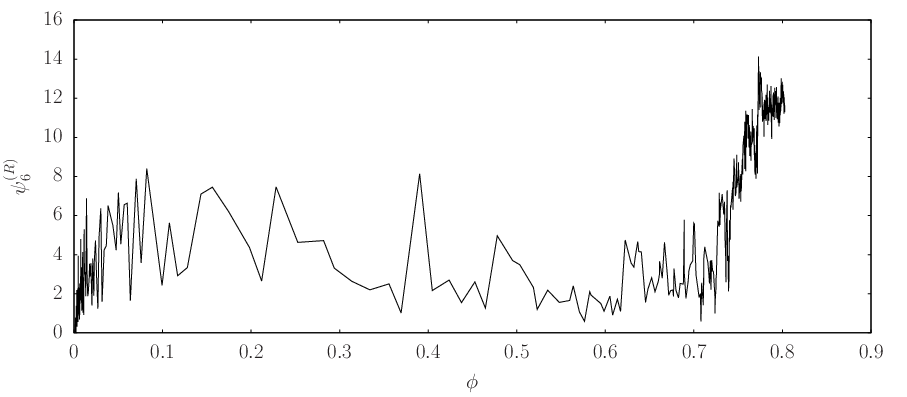

In [8]:
n = 100; r = 0.5; R = 10*r;
box = Box(n,r)

gp = Gnuplot("psi6.png", 32,14)
write(gp.f, "set xlabel '\$\\phi\$'; set ylabel '\$\\psi_6^{(R)}\$';
    plot '-' w l notitle\n")
for i = 1:1000
    phi = getDensity(box)
    psi = psi6(box.pts, R)
    write(gp.f, "$phi $psi\n")
    for j in 1:100
        for k in 1:length(box.pts)*2
            montecarlo!(box)
        end
        reduceVolume!(box)
    end
end
plot(gp)

[10] Repite el ejercicio 9, esta vez comenzando con un sistema muy denso y ordenado para después bajar la densidad. 

[11] Prueba diferentes velocidades con las que incrementes o disminuyas la densidad cerca del punto crítico. 